In [437]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from requests import get
from bs4 import BeautifulSoup
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

**Dataframe Preparation**

In [438]:
food = pd.read_csv('data/food-inspections.csv', sep=',')

In [439]:
food = food.drop(['Address','City', 'State','Zip', 'Zip Codes','Historical Wards 2003-2015', 'Community Areas', 'Census Tracts','Wards','Location'], axis=1)

In [440]:
food.rename(columns={"Inspection Date": "Year", "Inspection Type": "Type", "Facility Type": "Facility", "AKA Name": "Name"}, inplace=True)
food.head()

,Inspection ID,DBA Name,Name,License #,Facility,Risk,Year,Type,Results,Violations,Latitude,Longitude
0,2320830,"THE HOXTON, CHICAGO","THE HOXTON, CHICAGO",2694640.0,Restaurant,Risk 2 (Medium),2019-10-31T00:00:00.000,License,Pass,36. THERMOMETERS PROVIDED & ACCURATE - Comment...,41.885699,-87.648789
1,2320831,OGDEN PLAZA INC.,OGDEN PLAZA INC.,2475982.0,Grocery Store,Risk 3 (Low),2019-10-31T00:00:00.000,Canvass,Out of Business,NaN,41.855266,-87.712402
2,2320829,PLAZA FOOD AND LIQUOR,PLAZA FOOD AND LIQUOR,2689756.0,Grocery Store,Risk 3 (Low),2019-10-31T00:00:00.000,License,Not Ready,NaN,NaN,NaN
3,2320813,PLAZA FOOD AND LIQUOR,PLAZA FOOD AND LIQUOR,2689757.0,Grocery Store,Risk 3 (Low),2019-10-31T00:00:00.000,License,Fail,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,NaN,NaN
4,2320757,GADS HILL CENTER,GADS HILL CENTER,2698627.0,Daycare Above and Under 2 Years,Risk 1 (High),2019-10-30T00:00:00.000,License,Fail,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,41.816005,-87.700893


**Risk analysis:**

1) Pourcentage de 1, 2 et 3 sur chaque année

2) Différences niveaux pour même chaîne (lié à la position?)

3) Notes des chaînes/écoles

4) Distributions des notes par année

**1. Percentage distribution of risk level throughout the years** 

In [441]:
#Year cleaning (keep only the year value)
food.Year = food.Year.str.split("-").str[0]
food.head()

,Inspection ID,DBA Name,Name,License #,Facility,Risk,Year,Type,Results,Violations,Latitude,Longitude
0,2320830,"THE HOXTON, CHICAGO","THE HOXTON, CHICAGO",2694640.0,Restaurant,Risk 2 (Medium),2019,License,Pass,36. THERMOMETERS PROVIDED & ACCURATE - Comment...,41.885699,-87.648789
1,2320831,OGDEN PLAZA INC.,OGDEN PLAZA INC.,2475982.0,Grocery Store,Risk 3 (Low),2019,Canvass,Out of Business,NaN,41.855266,-87.712402
2,2320829,PLAZA FOOD AND LIQUOR,PLAZA FOOD AND LIQUOR,2689756.0,Grocery Store,Risk 3 (Low),2019,License,Not Ready,NaN,NaN,NaN
3,2320813,PLAZA FOOD AND LIQUOR,PLAZA FOOD AND LIQUOR,2689757.0,Grocery Store,Risk 3 (Low),2019,License,Fail,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,NaN,NaN
4,2320757,GADS HILL CENTER,GADS HILL CENTER,2698627.0,Daycare Above and Under 2 Years,Risk 1 (High),2019,License,Fail,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,41.816005,-87.700893


In [442]:
#Check for missing years
food.Year.isna().any()

False

We see that we have every year from 2010 to 2019 present

In [443]:
#risk distribution for every year
year_list = food.Year.unique().tolist()
year_list.sort()
all_risks =  [[0 for _ in range(3)] for _ in range(len(year_list))]
year = 0
for i in year_list:
    all_risks[year] = food[food.Year==i].Risk.value_counts().sort_index().tail(3).tolist()
    year += 1

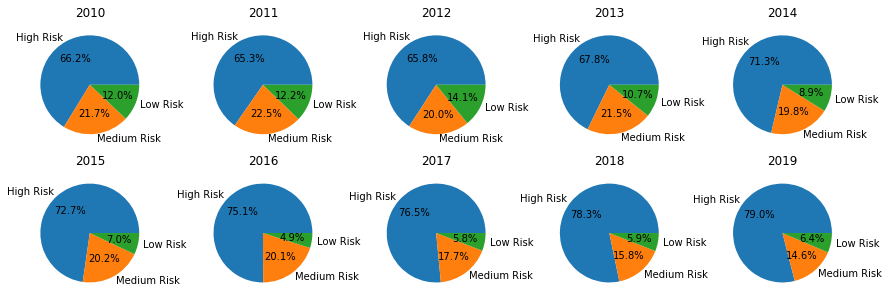

In [444]:
#plotting
labels = ['High Risk', 'Medium Risk', 'Low Risk']
fig, ax= plt.subplots(2,int(len(year_list)/2),figsize=(15,5))

year = 0
for i in range(2):
    for j in range(int(len(year_list)/2)):
        ax[i,j].pie(all_risks[year], labels = labels, autopct='%1.1f%%')
        ax[i,j].set_title(year_list[year])
        year += 1

plt.show()

**Discussion**

We see that the distribution of different risk levels has slowly changed since 2010. There is a slow increase in high risk aka fast foods 

**2. Most inspected facilities analysis**

First we need a visualization of the facilities to identify the cleaning needed. We will also concentrate only on data from the two last years to avoid the creation of any outlier or irrelevant data

In [445]:
newfood = food[food.Year.isin(['2018','2019'])].copy()
newfood.Name.value_counts().head(50)

SUBWAY                          528
DUNKIN DONUTS                   204
MCDONALD'S                      112
7-ELEVEN                        102
BURGER KING                      79
TACO BELL                        78
WENDY'S                          76
DUNKIN DONUTS/BASKIN ROBBINS     59
FRESHII                          56
WINGSTOP                         56
POTBELLY SANDWICH WORKS          51
MARIANO'S                        51
STARBUCKS COFFEE                 50
CHIPOTLE MEXICAN GRILL           47
CITGO                            46
JIMMY JOHN'S                     46
MCDONALDS                        45
POPEYES                          43
STARBUCKS                        40
CORNER BAKERY CAFE               36
PIZZA HUT                        35
MC DONALDS                       34
SUBWAY SANDWICHES                32
KFC                              32
WHOLE FOODS MARKET               31
HAROLD'S CHICKEN                 29
DOLLAR TREE                      28
KENTUCKY FRIED CHICKEN      

We see here some facilities are the same but with names slightly changed, so we need to adapt the data accordingly then we are going to make a deeper analysis on the these chains: McDonald's, Subway, Dunkin Donuts, Starbucks and Taco Bell. Why these restaurants ? Because they are all big chains which means they would normally follow the same standards but identifying different levels of risk might give us a clue of the quality of different locations in Chicago.

In [446]:
#Drop NaN's
newfood.dropna(subset=['Name'], inplace=True)
newfood.Name.isna().any()

False

In [447]:
#Top facilities cleaning (we will not take on account the cleaning of any facility other than the top 5)
newfood.Name = newfood.Name.str.upper()

In [448]:
#Let's see if there is other restaurants with "donald" to avoid adding wrong data to McDonald's
newfood[newfood["Name"].str.contains("DONALD")].Name.value_counts()

MCDONALD'S                               131
MCDONALDS                                 51
MC DONALDS                                41
MC DONALD'S                               18
MCDONALD'S  (T3 HK FOOD COURT)             6
MCDONALD'S RESTAURANT                      6
MCDONALD?S 28128                           5
MCDONALD'S RESTAURANT  (T3 H9)             5
MCDONALD'S  (T5 ARRIVAL)                   5
MCDONALDS  (T3  K9)                        5
MCDONALD'S  (T2  E/F)                      4
MCDONALDS RESTAURANT                       4
MCDONALD'S RESTAURANTS                     4
MCDONALD'S #5813                           3
MCDONALD?S                                 3
DONALDS FAMOUS HOT DOGS                    3
MC DONALD'S  (T3  L4)                      3
MCDONALD'S  (T1  B11)                      2
MCDONALDS #4655                            2
MCDONALD'S - MCCAFE'                       2
MCDONALDS (T1 C10)                         2
MCDONALD'S #490                            2
OFFICER DO

In [449]:
#removing other restaurants than McDonald's than unifying all McDonald's
removable = ['MARQUEZ', 'DOGS']
newfood = newfood[~newfood.Name.str.contains('|'.join(removable))]
newfood.loc[newfood.Name.str.contains("DONALD"), 'Name'] = "MCDONALDS"

In [450]:
newfood.Name.value_counts().head(10)

SUBWAY                          554
MCDONALDS                       316
DUNKIN DONUTS                   207
7-ELEVEN                        107
BURGER KING                      79
TACO BELL                        78
WENDY'S                          78
CHIPOTLE MEXICAN GRILL           63
DUNKIN DONUTS/BASKIN ROBBINS     59
WINGSTOP                         58
Name: Name, dtype: int64